In [1]:
# GHOST - Advection Test (2D)

import sys  
import numpy as np
import modepy as mp
sys.path.insert(0, '../src')
from Mesh import Mesh2D
from Discretization import SpatialDiscretization
from Solver import Solver

# discretization degree
p = 3

# geometry mapping degree
p_geo = 1

# read in mesh in GMSH format
mesh = Mesh2D("test", "../mesh/square_mesh_L1_x_6y_6.msh")

# set up periodic boundary conditions
left = np.array([1.0,0.0,0.0]) 
right = np.array([1.0,0.0,1.0])
bottom = np.array([0.0,1.0,0.0])
top = np.array([0.0,1.0,1.0])
mesh.add_bc_on_hyperplanes([left,right,bottom,top],[1,2,3,4])
mesh.make_periodic((1,2),[1]) # left-right periodic (bcs parallel to axis 1)
mesh.make_periodic((3,4),[0]) # top-bottom periodic (axis 0)

#curvilinear transformation used in Del Rey Fernandez et al. (2017)
mesh.map_mesh(f_map=Mesh2D.grid_transformation(warp_factor=0.2), p_geo=p_geo)

# volume and facet quadrature degrees
tau = 2*p
mu = 2*p+1

theta = np.pi/4
a = np.sqrt(2)

# solver parameters
params = {"project_title": "advection_p3b0c0t1",
         "problem": "constant_advection",
         "initial_condition": "sine",
         "wavelength": np.ones(2),
         "wave_speed": a*np.array([np.sin(theta),np.cos(theta)]),
         "upwind_parameter": 0.0,
         "integration_type": "quadrature",
         "solution_degree": p,
         "volume_quadrature_degree": tau,
         "facet_quadrature_degree": mu,
         "solution_representation": "modal",
         "form": "weak",
         "correction": "c_dg",
         "time_integrator": "rk44",
         "final_time": 1.0,
         "time_step_scale": 0.0025}

# set up solver
weak = Solver(params,mesh)
params_strong = params.copy()
params_strong["form"] = "strong"
strong = Solver(params_strong,mesh)

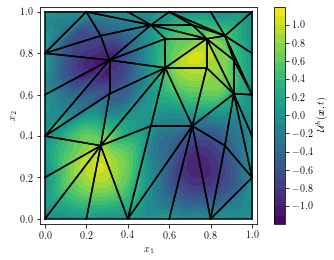

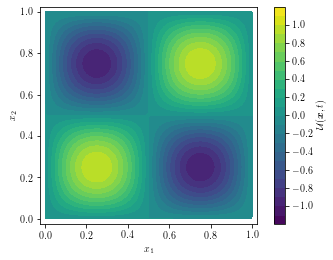

In [2]:
weak.load_solution(time_step=28000)
weak.post_process(error_quadrature_degree=4*p, visualization_resolution=50)
weak.plot(plot_curves=True,plot_exact=True)

In [ ]:
strong.run(write_interval=0.1)
strong.post_process(error_quadrature_degree=4*p)

In [ ]:
weak.run(write_interval=0.1)
weak.post_process(error_quadrature_degree=4*p)

In [ ]:
print("{:.3e}".format(strong.calculate_difference(weak)[0]), "&",
        "{:.3e}".format(strong.I_f[0] - strong.I_0[0]), "&",        
        "{:.3e}".format(weak.I_f[0] - weak.I_0[0]), "&",        
        "{:.3e}".format(strong.E_f[0] - strong.E_0[0]), "&",        
        "{:.3e}".format(weak.E_f[0] - weak.E_0[0]), "&",
        "{:.3e}".format(strong.calculate_error()[0]), "&",
        "{:.3e}".format(weak.calculate_error()[0]))